# Datamining on Stroke Dataset


In [92]:
# Standard imports
import warnings
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time

## Data Preprocessing (Exploration and Cleaning)

In [93]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Drop unnecessary columns

In [94]:
data.drop('id', axis=1, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Check for missing values

In [95]:
# Check for null values in every column
missing_gender = data['gender'].isnull().sum()
print("# of missing gender values: ", missing_gender)

missing_age = data['age'].isnull().sum()
print("# of missing age values: ", missing_age)

missing_hypertension = data['hypertension'].isnull().sum()
print("# of missing hypertension values: ", missing_hypertension)

missing_heart_disease = data['heart_disease'].isnull().sum()
print("# of missing heart_disease values: ", missing_heart_disease)

missing_ever_married = data['ever_married'].isnull().sum()
print("# of missing ever_married values: ", missing_ever_married)

missing_work_type = data['work_type'].isnull().sum()
print("# of missing work_type values: ", missing_work_type)

missing_Residence_type = data['Residence_type'].isnull().sum()
print("# of missing Residence_type values: ", missing_Residence_type)

missing_avg_glucose_level = data['avg_glucose_level'].isnull().sum()
print("# of missing avg_glucose_level values: ", missing_avg_glucose_level)

missing_bmi = data['bmi'].isnull().sum()
print("# of missing bmi values: ", missing_bmi)

missing_smoking_status = data['smoking_status'].isnull().sum()
print("# of missing smoking_status values: ", missing_smoking_status)

missing_stroke = data['stroke'].isnull().sum()
print("# of missing stroke values: ", missing_stroke)

# of missing gender values:  0
# of missing age values:  0
# of missing hypertension values:  0
# of missing heart_disease values:  0
# of missing ever_married values:  0
# of missing work_type values:  0
# of missing Residence_type values:  0
# of missing avg_glucose_level values:  0
# of missing bmi values:  201
# of missing smoking_status values:  0
# of missing stroke values:  0


In [96]:
# Replace null values in BMI column with average BMI

# Find the bmi mean
bmi_mean = data['bmi'].mean()
print(f"bmi mean: {bmi_mean}")

data['bmi'].fillna(bmi_mean, inplace=True)
data.head()

bmi mean: 28.893236911794673


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


Standardize all numerical data

In [97]:
# Standardize the age, avg_glucose_level, and bmi columns
numerical_cols = ["age", "avg_glucose_level", "bmi"]
for c in numerical_cols:
    data[c] = (data[c] - data[c].mean()) / data[c].std()
    
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,1.051331,0,1,Yes,Private,Urban,2.706111,1.001136e+00,formerly smoked,1
1,Female,0.785993,0,0,Yes,Self-employed,Rural,2.121351,-5.999632e-15,never smoked,1
2,Male,1.626231,0,1,Yes,Private,Rural,-0.005028,4.685314e-01,never smoked,1
3,Female,0.255317,0,0,Yes,Private,Urban,1.437217,7.153482e-01,smokes,1
4,Female,1.582008,1,0,Yes,Self-employed,Rural,1.501038,-6.356489e-01,never smoked,1


Create box plots for all numerical data

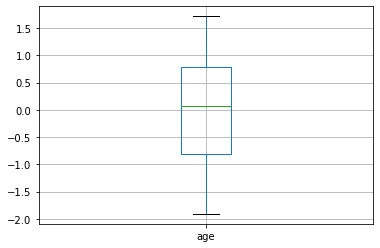

In [98]:
# Boxplot for age
data.boxplot(column=['age'])

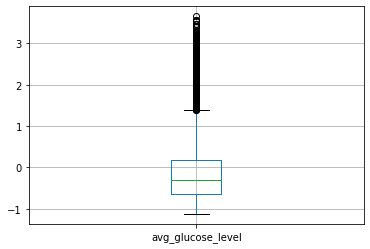

In [99]:
# Boxplot for glucode level
data.boxplot(column=['avg_glucose_level'])

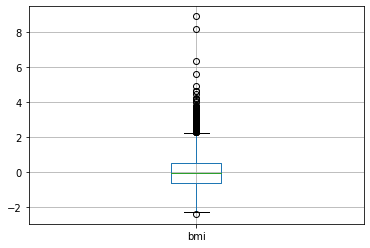

In [100]:
# Boxplot for BMI
data.boxplot(column=['bmi'])

Create bar charts for all categorical data

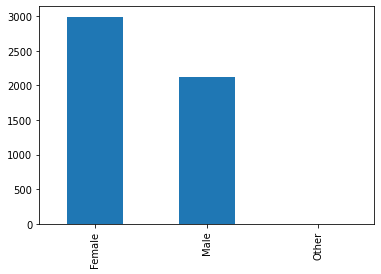

In [101]:
# Bar chart for gender counts
data["gender"].value_counts().plot(kind='bar')

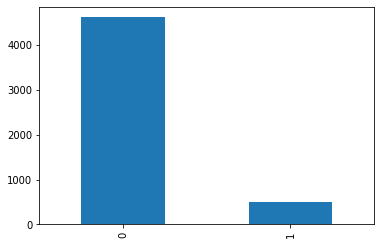

In [102]:
# Bar chart for hypertension counts
data["hypertension"].value_counts().plot(kind='bar')

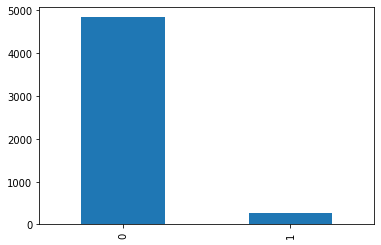

In [103]:
# Bar chart for heart_disease counts
data["heart_disease"].value_counts().plot(kind='bar')


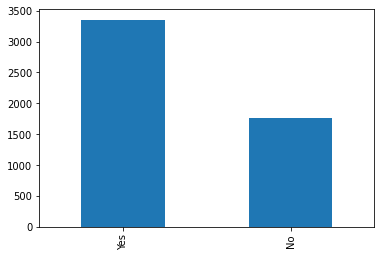

In [104]:
# Bar chart for ever_married counts
data["ever_married"].value_counts().plot(kind='bar')

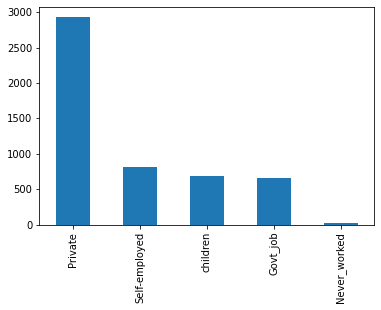

In [105]:
# Bar chart for work_type counts
data["work_type"].value_counts().plot(kind='bar')

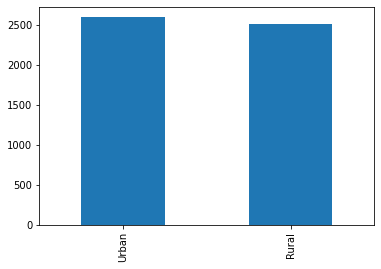

In [106]:
# Bar chart for Residence_type counts
data["Residence_type"].value_counts().plot(kind='bar')

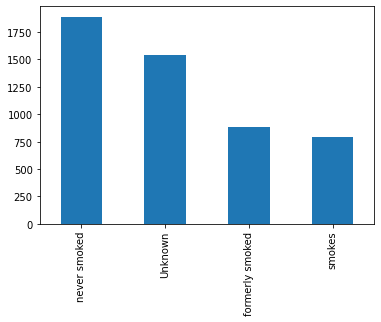

In [107]:
# Bar chart for smoking_status counts
data["smoking_status"].value_counts().plot(kind='bar')

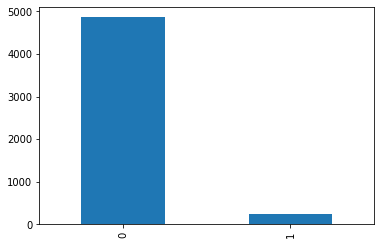

In [108]:
# Bar chart for stroke counts
data["stroke"].value_counts().plot(kind='bar')

In [109]:
# Remove some outliers

# From average glucose level
data = data[(np.abs(stats.zscore(data["avg_glucose_level"])) < 3)]

# From BMI
data = data[(np.abs(stats.zscore(data["bmi"])) < 3)]

print(f"New dataset shape: {data.shape}")
data.head()

New dataset shape: (5002, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,1.051331,0,1,Yes,Private,Urban,2.706111,1.001136e+00,formerly smoked,1
1,Female,0.785993,0,0,Yes,Self-employed,Rural,2.121351,-5.999632e-15,never smoked,1
2,Male,1.626231,0,1,Yes,Private,Rural,-0.005028,4.685314e-01,never smoked,1
3,Female,0.255317,0,0,Yes,Private,Urban,1.437217,7.153482e-01,smokes,1
4,Female,1.582008,1,0,Yes,Self-employed,Rural,1.501038,-6.356489e-01,never smoked,1


**One-Hot Encoding**


Create a version of the dataset that is one-hot encoded

In [110]:
hot_data = data.copy()
categorical_columns = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

for c in categorical_columns:
    vals = hot_data[c].unique()
    for v in vals:
        hot_data[f"{c}_{v}"] = hot_data[c].apply(lambda c_val: 1 if c_val == v else 0)
    hot_data.drop(c, axis=1, inplace=True)
print(hot_data.shape)
hot_data.head()

(5002, 22)


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Female,gender_Other,ever_married_Yes,ever_married_No,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Urban,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,1.051331,0,1,2.706111,1.001136e+00,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
1,0.785993,0,0,2.121351,-5.999632e-15,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0
2,1.626231,0,1,-0.005028,4.685314e-01,1,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
3,0.255317,0,0,1.437217,7.153482e-01,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0
4,1.582008,1,0,1.501038,-6.356489e-01,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0


## Data Mining (Testing Different Models)

In [113]:
# Separating labels from the rest of the data
data_Y = data['stroke']
data_X = data.drop(['stroke'], axis=1)
print(data_X.shape)
print(data_Y.shape)

hot_data_Y = hot_data['stroke']
hot_data_X = hot_data.drop(['stroke'], axis=1)

(5002, 10)
(5002,)


**Decision Trees**

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score

print("\nUsing criterion: Entropy")
clf = DecisionTreeClassifier(criterion='entropy')
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: Gini")
clf = DecisionTreeClassifier(criterion='gini')
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: max_depth of 10")
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: max_depth of 1")
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: min_samples_split = 20")
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=20)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: min_samples_leaf = 10")
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")

print("\nUsing criterion: min_impurity_decrease = .9")
clf = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=.9)
scores = cross_val_score(clf, hot_data_X, hot_data_Y, cv=10)
print(f"Accuracy: {scores.mean() * 100}")


Using criterion: Entropy
Accuracy: 91.60331337325348

Using criterion: Gini
Accuracy: 91.16383233532935

Using criterion: max_depth of 10
Accuracy: 93.46271457085828

Using criterion: max_depth of 1
Accuracy: 95.22191616766466

Using criterion: min_samples_split = 20
Accuracy: 93.02299401197604

Using criterion: min_samples_leaf = 10
Accuracy: 92.12319361277446

Using criterion: min_impurity_decrease = .9
Accuracy: 95.22191616766466


So far, the best accuracy was produced by decreasing the max depth or using a min_impurity_decrease. We can further try more combinations using a GridSearchCV.

In [129]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

params = {
    "max_depth": [1, 3, 5, 10, 20], 
    "min_samples_split": [5, 10, 20], 
    "min_samples_leaf": [1, 3, 5, 10, 20], 
    "max_features": [1, 3, 5, 10, 20],
    "min_impurity_decrease": [.1, .3, .5, .9]}

grid_search = GridSearchCV(clf, params, cv=5, scoring="accuracy")
grid_search.fit(hot_data_X, hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'max_depth': 1, 'max_features': 1, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 95.22191808191808


In [132]:
preds = grid_search.predict(hot_data_X)
print("\nClassification Report:")
print(classification_report(hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4763
           1       0.00      0.00      0.00       239

    accuracy                           0.95      5002
   macro avg       0.48      0.50      0.49      5002
weighted avg       0.91      0.95      0.93      5002



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The "best" decision tree simply chooses the "no stroke" label every almost every time, which produces a poor f-score. We can try to fix this by undersampling the majority class.

In [159]:
num_stroke = hot_data["stroke"].sum()
print(f"number of records with stroke: {num_stroke}")

# sample equally
balanced_hot_data = hot_data.groupby('stroke').apply(lambda x: x.sample(num_stroke))
balanced_hot_data_Y = balanced_hot_data['stroke']
balanced_hot_data_X = balanced_hot_data.drop(['stroke'], axis=1)
balanced_hot_data.head()

number of records with stroke: 239


age  ...  smoking_status_Unknown
stroke                 ...                        
0      4814 -1.159821  ...                       1
       2284  0.387986  ...                       0
       863  -0.098468  ...                       0
       2459  1.582008  ...                       0
       1489 -0.584921  ...                       1

[5 rows x 22 columns]

In [160]:
# Generating another Decision Tree using balanced_hot_data
params = {
    "max_depth": [1, 3, 5, 10, 20], 
    "min_samples_split": [5, 10, 20], 
    "min_samples_leaf": [1, 3, 5, 10, 20], 
    "max_features": [1, 3, 5, 10, 20],
    "min_impurity_decrease": [.1, .3, .5, .9]}

grid_search = GridSearchCV(clf, params, cv=5, scoring="accuracy")
grid_search.fit(balanced_hot_data_X, balanced_hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'max_depth': 1, 'max_features': 20, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 74.25657894736842


In [161]:
preds = grid_search.predict(balanced_hot_data_X)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.59      0.71       239
           1       0.69      0.94      0.80       239

    accuracy                           0.76       478
   macro avg       0.80      0.76      0.76       478
weighted avg       0.80      0.76      0.76       478



The average f-score is greatly improved now! However, we only have a 74.25% accuracy.

**Naive Bayes**

In [173]:
from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

# Use a gaussian Naive Bayes with 10-fold cross validation
gnb = GaussianNB()
preds = cross_val_predict(gnb, balanced_hot_data_X, balanced_hot_data_Y, cv=10)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.31      0.47       239
           1       0.59      0.98      0.74       239

    accuracy                           0.65       478
   macro avg       0.77      0.65      0.60       478
weighted avg       0.77      0.65      0.60       478



Standard gaussian Naive Bayes produces a low accuracy and f-score compared to the decision tree.

**K-Nearest Neighbors**


Since KNN suffers from the curse of dimensionality, we will have to perform dimensionality reduction. We use a GridSearchCV to perform hyperparamter tuning.

In [168]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

pca = PCA()
knn = KNeighborsClassifier(n_neighbors=7)
pline = Pipeline(steps=[("pca", pca), ("knn", knn)])

param_grid = {
    'pca__n_components': list(range(5, 21)),
    'knn__n_neighbors': list(range(1, 25))
}

grid_search = GridSearchCV(pline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(hot_data_X, hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'knn__n_neighbors': 8, 'pca__n_components': 6}
Accuracy: 95.22191808191808


In [170]:
preds = grid_search.predict(hot_data_X)
print("\nClassification Report:")
print(classification_report(hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4763
           1       1.00      0.00      0.01       239

    accuracy                           0.95      5002
   macro avg       0.98      0.50      0.49      5002
weighted avg       0.95      0.95      0.93      5002



Again, this produces a poor f-score so we will try again on the balanced one-hot-encoded dataset

In [171]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

grid_search.fit(balanced_hot_data_X, balanced_hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'knn__n_neighbors': 13, 'pca__n_components': 5}
Accuracy: 75.92763157894737


In [172]:
preds = grid_search.predict(balanced_hot_data_X)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       239
           1       0.74      0.88      0.80       239

    accuracy                           0.78       478
   macro avg       0.79      0.78      0.78       478
weighted avg       0.79      0.78      0.78       478



This model appears to be more successful than the one built using a decision tree.

**Support Vector Machines**

We again use a GridSearchCV to perform hyperparamter tuning. We will also use the balanced one-hot-encoded dataset.

In [176]:
from sklearn.svm import SVC

pca = PCA()
svc = SVC()
pline = Pipeline(steps=[("pca", pca), ("svc", svc)])

param_grid = {
    'pca__n_components': list(range(5, 19)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(balanced_hot_data_X, balanced_hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'pca__n_components': 6, 'svc__kernel': 'rbf'}
Accuracy: 76.14912280701753


In [177]:
preds = grid_search.predict(balanced_hot_data_X)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       239
           1       0.73      0.85      0.79       239

    accuracy                           0.77       478
   macro avg       0.78      0.77      0.77       478
weighted avg       0.78      0.77      0.77       478



**Random Forests**

In [178]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
param_grid = {
    'max_depth': list(range(5, 61, 5)),
    'min_samples_leaf': [2, 31, 4],
    'max_features': ["sqrt", "log2"]
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring="accuracy")
grid_search.fit(balanced_hot_data_X, balanced_hot_data_Y)
print(grid_search.best_params_)
print(f"Accuracy: {grid_search.best_score_*100}")

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2}
Accuracy: 76.77631578947368


In [179]:
preds = grid_search.predict(balanced_hot_data_X)
print("\nClassification Report:")
print(classification_report(balanced_hot_data_Y, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       239
           1       0.94      0.95      0.95       239

    accuracy                           0.95       478
   macro avg       0.95      0.95      0.95       478
weighted avg       0.95      0.95      0.95       478



Random Forests produce the best f-score and accuracy by far!